In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib import rc
import os, sys, time
import scipy.interpolate as interp

import astropy.constants as const
import astropy.units as u
from astropy.cosmology import z_at_value
from astropy.cosmology import WMAP9 as cosmo
from fractions import Fraction

import hasasia.sensitivity as hassens
import hasasia.sim as hassim
import hasasia.skymap as hassky

import gwent
from gwent import detector,utils,binary,snr

In [3]:
rc('text',usetex=True)
rc('font',**{'family':'serif','serif':['Times New Roman'],'size':14})#,'weight':'bold'})

In [4]:
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index('DetectorDesignSensitivities')
top_directory = "/".join(splt_path[0:top_path_idx+1])

sys.path.insert(0,top_directory + '/Functions')
import HorizonDistance as HD

load_directory = gwent.__path__[0] + '/LoadFiles/InstrumentFiles/'

In [5]:
fig_save_idx = splt_path.index('Research')
fig_save_location = "/".join(splt_path[0:fig_save_idx+1])
fig_save_location += '/paperfigs'

In [6]:
axissize = 14
labelsize = 16
legendsize = 12
figsize = (10,8)
colornorm = colors.Normalize(vmin=0.0, vmax=5.0)
linesize = 3

In [7]:
'''
NOT REALLY YET.
    Variables: 
        GLOBAL:
            'T_obs' - Observation Time
        SOURCE:
            'M' - Mass (Solar Units)
            'q' - Mass Ratio
            'chi1' - Spin1
            'chi2' - Spin2
            'z' - Redshift
        LISA ONLY:
            'L' - Armlength
            'A_acc' - Acceleration Noise
            'A_IMS' - Optical Metrology
            'f_acc_break_low'
            'f_acc_break_high'
            'f_IMS_break'
        PTAs ONLY:
            'N_p' - Number of Pulsars
            'sigma' - Timing Error RMS
            'cadence' - cadence
'''
var_x = 'M' #Variable on x-axis

sampleRate_x = 100 #Number of x-axis points

In [8]:
#Selects which noise curve:
#							0 is Einstein Telescope, 
#							1 is aLIGO, 
#							2 is NANOGrav 15yr,
#							3 is SKA (2030s),
#							4 is Neil Cornish's,
#							anything else is the L3 proposal

# Source Selection

In [9]:
def Get_Source(model):
    if model == 0 or model == 1:
        #M = m1+m2 Total Mass
        M = 1e2
        M_min = 1e0
        M_max = 1e5
    elif model == 2 or model == 3:
        #M = m1+m2 Total Mass
        M = 1e8
        M_min = 5e7
        M_max = 1e11
    else:
        #M = m1+m2 Total Mass
        M = 1e6
        M_min = 1e1
        M_max = 1e10

    #q = m2/m1 reduced mass
    q = 1.0
    q_min = 1.0
    q_max = 18.0

    #Chi = S_i*L/m_i**2, spins of each mass i
    chi1 = 0.0 #spin of m1
    chi2 = 0.0 #spin of m2
    chi_min = -0.85 #Limits of PhenomD for unaligned spins
    chi_max = 0.85

    z = 3.0 #Redshift
    z_min = 1e-2
    z_max = 1e3

    source = binary.BBHFrequencyDomain(M,q,z,chi1,chi2)
    source.M = [M,M_min,M_max]
    source.q = [q,q_min,q_max]
    source.chi1 = [chi1,chi_min,chi_max]
    source.chi2 = [chi2,chi_min,chi_max]
    source.z = [z,z_min,z_max]

    return source

# Model Selection

In [10]:
def Get_Instrument(model):
    if model == 0: #Einstein Telescope
        #Loaded from http://www.et-gw.eu/index.php/etsensitivities
        load_name = 'ET_D_data.txt'
        load_location = load_directory + 'EinsteinTelescope/StrainFiles/' + load_name

        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr

        instrument = detector.GroundBased('ET',T_obs,load_location=load_location,I_type='A')
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]

    elif model == 1: #aLIGO
        #Loaded from https://dcc.ligo.org/T1800044/public
        load_name = 'aLIGODesign.txt'
        load_location = load_directory + 'aLIGO/StrainFiles/' + load_name

        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr

        instrument = detector.GroundBased('aLIGO',T_obs,load_location=load_location,I_type='A')
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]

    elif model == 2: #NANOGrav 15 yr
        #NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
        T_obs = 15*u.yr #Observing time in years
        T_obs_min = 10*u.yr
        T_obs_max = 30*u.yr

        sigma = 100*u.ns.to('s')*u.s #rms timing residuals in seconds

        N_p = 18 #Number of pulsars

        cadence = 1/(2*u.wk.to('yr')*u.yr) #Avg observation cadence of 1 every 2 weeks in num/year

        instrument = detector.PTA('NANOGrav',T_obs,N_p,sigma,cadence)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]


    elif model == 3: #SKA (2030s)
        #SKA calculation using parameters and methods from https://arxiv.org/abs/0804.4476 section 7.1
        T_obs = 15*u.yr #Observing time (years)
        T_obs_min = 10*u.yr
        T_obs_max = 30*u.yr

        sigma = 10*u.ns.to('s')*u.s #rms timing residuals in nanoseconds

        N_p = 20 #Number of pulsars

        cadence = 1/(u.wk.to('yr')*u.yr) #Avg observation cadence of 1 every week in num/year

        instrument = detector.PTA('SKA',T_obs,N_p,sigma,cadence)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]

    elif model == 4: #Robson,Cornish,and Liu 2019, LISA (https://arxiv.org/abs/1803.01944)
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr

        L = 2.5e9*u.m #armlength in meters
        L_min = 1.0e7*u.m
        L_max = 1.0e11*u.m

        A_acc = 3e-15*u.m/u.s/u.s #M/s**2
        A_IMS = 1.5e-11*u.m
        f_IMS_break = 2.*u.mHz.to('Hz')*u.Hz
        f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
        f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
        Background = False
        T_type = 'A'

        instrument = detector.SpaceBased('Alt_LISA',\
                                       T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IMS,f_IMS_break,\
                                       Background=Background,T_type=T_type)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        instrument.L = [L,L_min,L_max]

    else: #L3 proposal
        #Default Params from https://arxiv.org/abs/1702.00786
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr

        L = 2.5e9*u.m #armlength in meters
        L_min = 1.0e7*u.m
        L_max = 1.0e11*u.m

        f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
        f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
        f_IMS_break = 2.*u.mHz.to('Hz')*u.Hz
        A_acc = 3e-15*u.m/u.s/u.s
        A_IMS = 10e-12*u.m
        Background = False
        T_type = 'N'

        instrument = detector.SpaceBased('LISA_ESA',\
                                       T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IMS,f_IMS_break,\
                                       Background=Background,T_type=T_type)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        instrument.L = [L,L_min,L_max]

    return instrument

# Horizon Distance Calculation

In [35]:
rho_thresh = 5
model = 3
instrument = Get_Instrument(model)
source = Get_Source(model)
start = time.time()
[sample_x,DL_min,DL_max] = HD.getHorizonDistance(source,instrument,var_x,sampleRate_x,rho_thresh)
end = time.time()
print(end-start)

Multiple roots  Mass:  49999999.99999999 solMass  z_vals:  [ 29387.80407843 229269.36237086]

Multiple roots  Mass:  53990051.491290495 solMass  z_vals:  [ 24247.14118721 224880.56930768]

Multiple roots  Mass:  58298513.200644106 solMass  z_vals:  [ 20004.35845779 220024.11794544]

Multiple roots  Mass:  62950794.59136909 solMass  z_vals:  [ 16502.66039405 214814.17700476]

Multiple roots  Mass:  67974332.82811351 solMass  z_vals:  [ 13612.63650393 209379.47457453]

Multiple roots  Mass:  73398754.58951935 solMass  z_vals:  [ 11227.47877637 203853.66428842]

Multiple roots  Mass:  79256050.79369505 solMass  z_vals:  [  9259.03405565 198305.18010377]

Multiple roots  Mass:  85580765.26695862 solMass  z_vals:  [  7634.54575186 192740.57586074]

Multiple roots  Mass:  92410198.46854304 solMass  z_vals:  [  6293.96444115 187167.56012018]

103.36847710609436


In [ ]:
HD.plotHD(source,instrument,var_x,sample_x,DL_max,DL_min=DL_min,display=True,figloc=None,z_axis=True)

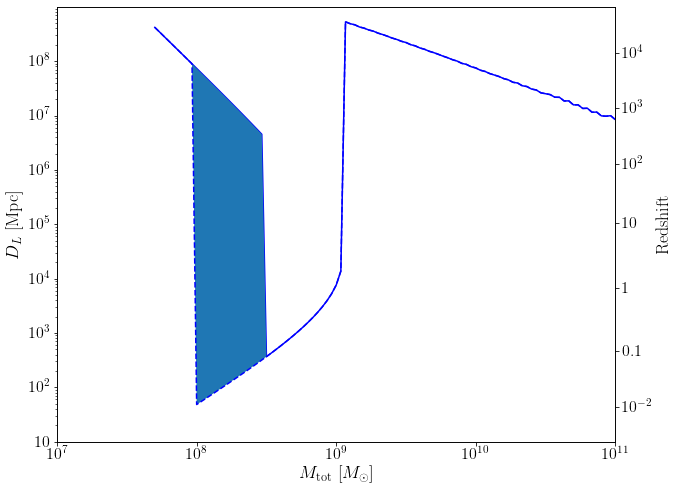

In [34]:
HD.plotHD(source,instrument,var_x,sample_x,DL_max,DL_min=DL_min,display=True,figloc=None,z_axis=True)

In [13]:
def Get_rho_z(z,source,instrument):
    setattr(source,'z',z)
    source.Check_Freq_Evol()
    if source.ismono: #Monochromatic Source
        if hasattr(source,'h_gw'):
            del source.h_gw
        rho_z = snr.Calc_Mono_SNR(source,instrument)
    else: #Chirping Source
        if hasattr(source,'f'):
            del source.f
        if hasattr(source,'h_f'):
            del source.h_f
        rho_z = snr.Calc_Chirp_SNR(source,instrument)
    return rho_z

In [25]:
rho_thresh = 5.0
model = 2
instrument = Get_Instrument(model)
source = Get_Source(model)
source.M = 1e10*u.Msun
source.instrument = instrument
z_range = np.logspace(-2,4,200)
rho = np.zeros(len(z_range))
for i,z in enumerate(z_range):
    rho[i] = Get_rho_z(z,source,instrument)

In [29]:
rho_interp = interp.InterpolatedUnivariateSpline(z_range,rho-rho_thresh)
z_val = rho_interp.roots()
print(z_val)

[3784.08623378]


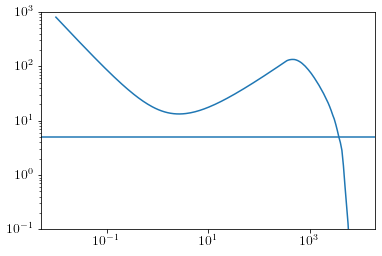

In [28]:
rho_thresh = 5
plt.figure()
plt.plot(z_range,rho)
plt.axhline(y=rho_thresh)
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-1,1e3])
plt.show()

# Whole Hog creation of Horizon Distances

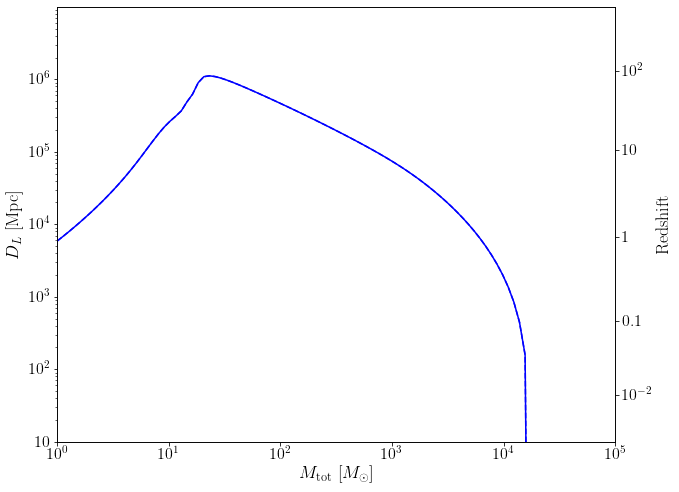

Model:  ET ,  done. t = :  62.83009314537048


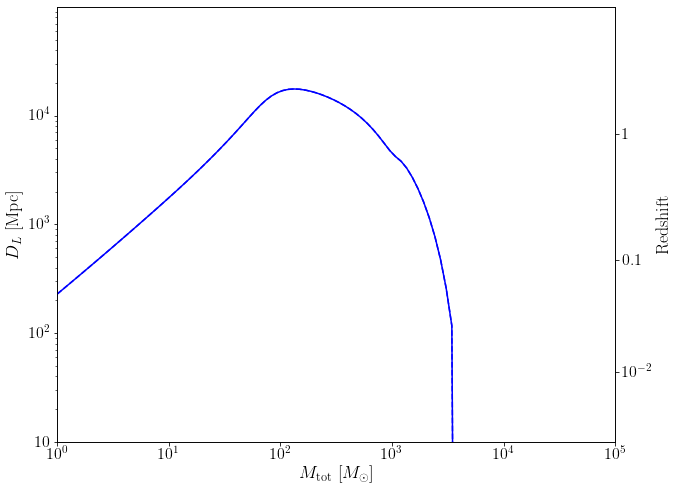

Model:  aLIGO ,  done. t = :  62.78122282028198
Multiple roots  Mass:  500359470.4695012 solMass  z_vals:  [1.09133745e-02 5.29997883e+03]

Multiple roots  Mass:  540288671.4960655 solMass  z_vals:  [1.24162800e-02 4.36658365e+03]

Multiple roots  Mass:  583404263.8846716 solMass  z_vals:  [1.41339754e-02 3.59756306e+03]

Multiple roots  Mass:  629960524.9474356 solMass  z_vals:  [1.60902201e-02 2.96291293e+03]

Multiple roots  Mass:  680232023.5878503 solMass  z_vals:  [1.83227194e-02 2.43947912e+03]

Multiple roots  Mass:  734515239.590657 solMass  z_vals:  [2.08701961e-02 2.00772825e+03]

Multiple roots  Mass:  793130312.1327447 solMass  z_vals:  [2.37794526e-02 1.65169277e+03]

Multiple roots  Mass:  856422927.8270022 solMass  z_vals:  [2.71038152e-02 1.35813985e+03]

Multiple roots  Mass:  924766359.4340342 solMass  z_vals:  [3.09055214e-02 1.11616122e+03]

Multiple roots  Mass:  998563667.2651374 solMass  z_vals:  [3.52569033e-02 9.16744262e+02]

Multiple roots  Mass:  1078250076

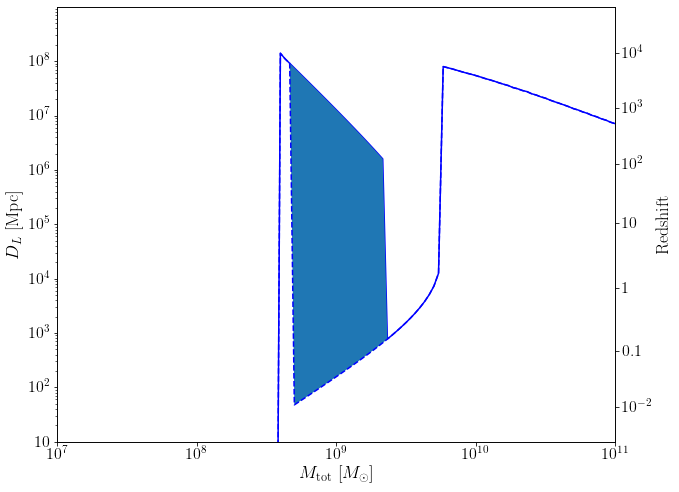

Model:  NANOGrav ,  done. t = :  47.72243905067444
Multiple roots  Mass:  99784627.47274026 solMass  z_vals:  [1.10686999e-02 5.18772492e+03]

Multiple roots  Mass:  107747543.50584976 solMass  z_vals:  [1.25939217e-02 4.27492895e+03]

Multiple roots  Mass:  116345908.43881808 solMass  z_vals:  [1.43362255e-02 3.52180084e+03]

Multiple roots  Mass:  125630431.74825542 solMass  z_vals:  [1.63208855e-02 2.90048279e+03]

Multiple roots  Mass:  135655869.57922763 solMass  z_vals:  [1.85858653e-02 2.38795924e+03]

Multiple roots  Mass:  146481347.67356548 solMass  z_vals:  [2.11705724e-02 1.96524425e+03]

Multiple roots  Mass:  158170710.06818885 solMass  z_vals:  [2.41225807e-02 1.61666012e+03]

Multiple roots  Mass:  170792895.6199103 solMass  z_vals:  [2.74960750e-02 1.32925874e+03]

Multiple roots  Mass:  184422344.5773116 solMass  z_vals:  [3.13543582e-02 1.09235808e+03]

Multiple roots  Mass:  199139437.59747106 solMass  z_vals:  [3.57709928e-02 8.97129953e+02]

Multiple roots  Mass: 

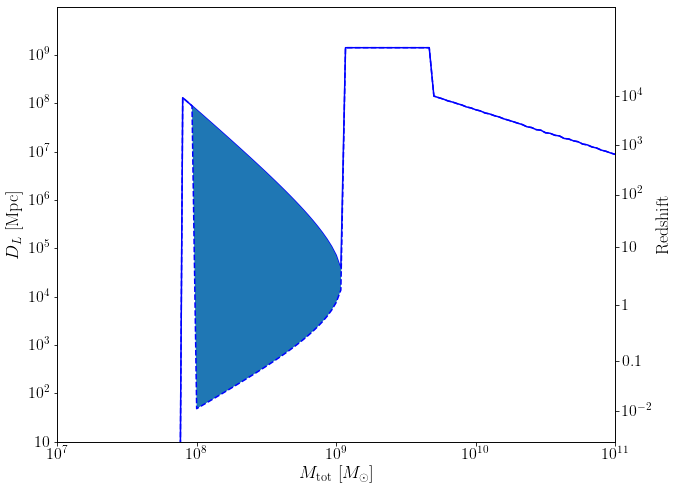

Model:  SKA ,  done. t = :  54.14945888519287


CosmologyError: Best guess z is very close the upper z limit.
Try re-running with a different zmax.

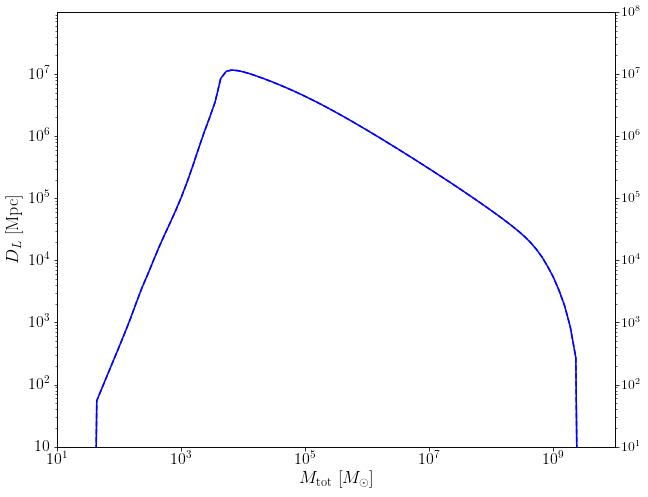

In [30]:
models = [0,1,2,3,4,5]
for model in models:
    instrument = Get_Instrument(model)
    source = Get_Source(model)
    start = time.time()
    [sample_x,DL_min,DL_max] = HD.getHorizonDistance(source,instrument,var_x,sampleRate_x,rho_thresh)
    end = time.time()
    #snr.Save_SNR(sample_x,sample_y,SNRMatrix,save_location,SNR_save_name,Sample_save_name)
    HD.plotHD(source,instrument,var_x,sample_x,DL_max,DL_min=DL_min,display=True,figloc=None,z_axis=True)
    print('Model: ',instrument.name,',',' done. t = : ',end-start)